In [1]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
!nvidia-smi

Sun Jul  3 10:36:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   35C    P8     1W / 250W |   8035MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [4]:
# !kill -9 3980682

In [5]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 149
# print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [7]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [8]:
!ls
data_zip_file = './local1_folder.zip'
# data_zip_file2 = './local1_folder_temp.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal-Copy1.ipynb
Attetion-Multimodal-copy2-Copy1.ipynb
Attetion-Multimodal-copy2.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-LateFusion-Copy1.ipynb
Attetion-Multimodal-LateFusion.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception-Attetion-Copy1.ipynb
Inception-Attetion-Copy2.ipynb
Inception-Attetion.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_f1_latefusion.pth.tar
my_checkpoint_attention_f1_latefusion_seed_0.pth.tar
my_checkpoint_attention_f1_latefusion_seed_149.pth.tar
my_checkpoint_attention_f1_latefusion_seed_52.pth.tar
my_checkpoint_attention_f1_latefusion_seed_65.pth.tar
my_checkpoint_attention_f1_latefusion_seed_66.pth.tar
my_che

In [9]:
!nvidia-smi

Sun Jul  3 10:36:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   35C    P8     1W / 250W |   8035MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Data preprocessing

## Image data

In [10]:
data_zip = zipfile.ZipFile(data_zip_file)

In [11]:
len(data_zip.namelist())

58766

In [12]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

True

local1_folder-1/foody-nuoc-ep-hoa-qua-nguyen-chat-958-637065597443705394.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x7F10D6A9E290>
(600, 800, 3)


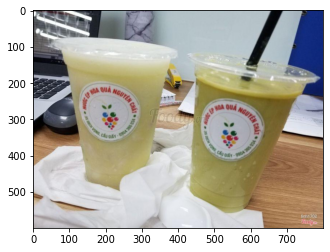

In [13]:
img_path = 'local1_folder-1/foody-nuoc-ep-hoa-qua-nguyen-chat-958-637065597443705394.jpg'
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [14]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [15]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)


data_df1[['Comment', 'Rating']].head()

,Comment,Rating
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",1.0


In [16]:
data_df4.shape

(3093, 11)

In [17]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [18]:
data_df.shape

(14174, 11)

In [19]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [20]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 0
image_urls              0
Food_score_cmt          0
Services_score_cmt      0
Atmosphere_score_cmt    0
Position_score_cmt      0
Price_score_cmt         0
Rating                  0
dtype: int64

In [21]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.0,9.0,5.0,5.0,5.0,5.8
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,8.0,9.0
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,10.0,9.4
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,1.0,5.0,5.0,6.0,6.0,4.6
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [23]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 8) & (data_df['score'] <= 8)][['Comment','score']].sort_values(by=['score'])

,Comment,score
8,Giữa cái thời tiết HN sớm trưa mưa nắng thất t...,8.0
9677,Sáng nào mình cx phải ăn phở ở đây ms chịu đc ...,8.0
9701,"Hàng xôi tấp nập người ghé ăn & mua mang đi, n...",8.0
9705,"Quán chè nhỏ nhỏ, đối diện bakery Tati. Cô chủ...",8.0
9713,❤ Vị trí : hàng này mới mở dạo gần đây. Nằm ng...,8.0
...,...,...
4892,* mùa dịch ăn gì ??🤔🤔\nĐang mùa dịch thế này c...,8.0
4907,Suất đặc biệt cơm gà + sườn ship Now,8.0
4955,Chè sầu chính hãng nè cả nhà 😻 viêm họng mà vẫ...,8.0
5034,"Nhân ngày xe bus hỏng đúng quán ding tea, mình...",8.0


In [24]:
data_df['Comment'][8]

'Giữa cái thời tiết HN sớm trưa mưa nắng thất thường, tối phần phật gió như này thì việc ngồi nhâm nhâm nhi nhi em caramen hoa quả này là 1 điều thật tuyệt - thơm thơm ngậy ngậy của caramen, vị thanh mát của các loại hoa quả: dưa hấu, xoài, thanh long, mít....được kết hợp lại với nhau rất thú vị, cốc còn rất là đầy đặn nữa chứ. Cơ mà anh chị chủ quán làm ngon quá đi, cứ bị nghiện ý, mỗi ngày sẽ nếm 1 vị: sữa chua thạch lá nếp nè, sc hoa quả, chè khoai dẻo nè.....chu choa v.v.....vân vân và mây mây...'

In [25]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

In [26]:
data_df = data_df[data_df['label'] != 2]

1    6953
0    3023
Name: label, dtype: int64


<AxesSubplot:>

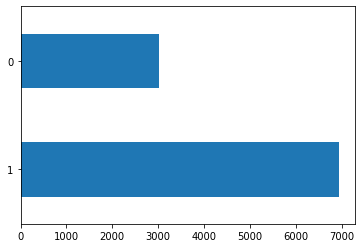

In [27]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [28]:
data_df[['Comment','label', 'score']].head()

,Comment,label,score
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,0,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",1,9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",1,9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,0,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",0,1.0


In [29]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,0


In [30]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [31]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [32]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

1    6952
0    3023
Name: label, dtype: int64


<AxesSubplot:>

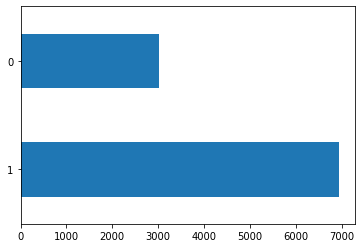

In [33]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [34]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [35]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [36]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [37]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(9, 8)

In [38]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    vị_trí ở mặt đường nhưng ở cạnh quán mì cay to...
4188    thật tuyệt_cú mèo luôn mỗi cốc hoa_quả dầm ở đ...
4189    mình đã ăn_ở địa_điểm 211 chùa láng được hơn 1...
4190    nghe mọi người khen quán này dữ lém nên hôm_na...
Name: preprocess_comment, dtype: object

In [39]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

314     1
415     1
744     1
1011    1
1077    1
1543    1
1779    1
1808    1
1888    1
2302    1
2337    1
2528    1
2836    1
2873    1
2976    1
3489    1
3643    1
4328    1
4409    1
4645    1
5242    1
5564    1
5976    1
6341    1
6487    1
6748    1
7554    1
7603    1
8684    1
8881    1
9377    1
9523    1
Name: preprocess_comment, dtype: int64

In [40]:
a

0        56
1        43
2        38
3        34
4        74
       ... 
9970     42
9971     48
9972    107
9973    185
9974     17
Name: preprocess_comment, Length: 9975, dtype: int64

In [41]:
data_df['Comment'][195]

'Sữa chua mít + trà đào ngon, caramen trong sữa chua ăn cũng ok, giá vừa phải. Quán sạch sẽ, nhân viên phục vụ tốt. Sẽ quay lại.'

<AxesSubplot:>

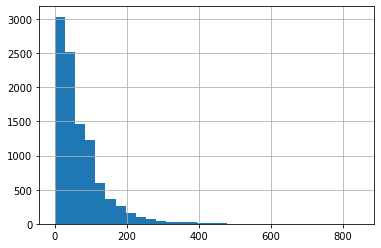

In [42]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

<AxesSubplot:>

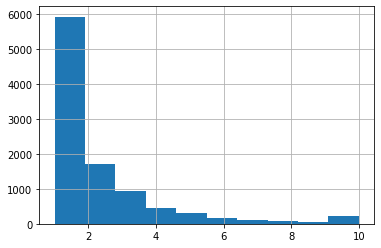

In [43]:
img_len = [len(i.split(',')) for i in data_df['image_urls']]

pd.Series(img_len).hist(bins = 10)

In [44]:
img_len = pd.DataFrame(img_len)
img_len.value_counts()

1     5930
2     1699
3      940
4      454
5      320
10     210
6      178
7      121
8       75
9       48
dtype: int64

In [45]:
img_len.mean()

0    2.066266
dtype: float64

In [46]:
data_df_0 = data_df[data_df['label']==0].reset_index(drop=True)
data_df_0

,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
2,4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...
3,8,5818974,16441515,968327,Bạn nào đặt nên cẩn thận,local1_folder-1/foody-com-ga-123-nguyen-khang-...,1.0,0,bạn nào đặt nên cẩn_thận
4,9,2249624,1301558,187189,Trước mình rất hay ăn ở quán vì đồ ngon và giá...,local1_folder-1/foody-chao-ngon-ha-noi-115-636...,5.4,0,trước mình rất hay ăn_ở quán vì đồ ngon và giá...
...,...,...,...,...,...,...,...,...,...
3018,9963,2696287,14581928,184590,"Mọi người đến ăn cẩn thận nha, nhân viên bê hế...",local1_folder-1/foody-lau-de-nhat-ly-15-hang-c...,3.0,0,mọi người đến ăn cẩn_thận nha nhân_viên bê hết...
3019,9964,3369673,11754103,184590,Mọi thứ đều quá bình thường. Lan dau tien min...,local1_folder-1/foody-lau-de-nhat-ly-15-hang-c...,1.8,0,mọi thứ đều quá bình_thường lan dau tien minh ...
3020,9969,2338059,876582,165697,Không ngon lắm. Phần bún chả 45k. Ủa mà mình k...,local1_folder-1/foody-bun-cha-bat-su-523-63675...,5.0,0,không ngon lắm phần bún_chả 45k ủa mà mình khô...
3021,9971,2843371,11115693,19123,Quán này giờ chia làm 2 quán\n1 quán đối diện ...,local1_folder-1/foody-banh-mi-sot-vang-dinh-ng...,2.6,0,quán này giờ chia làm 2 quán 1 quán đối_diện c...


2588
2


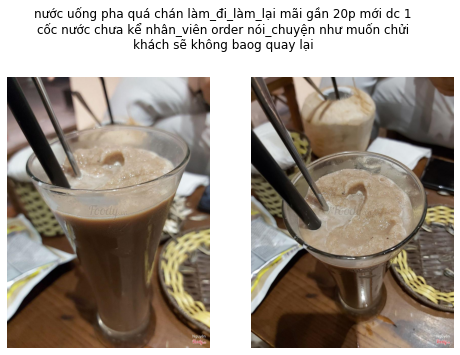

In [47]:
from textwrap import wrap

row_pos = np.random.randint(0,3000)
print(row_pos)
len_image_list = data_df_0.iloc[row_pos]['image_urls'].split(',')
print(len(len_image_list))
i=1
fig = plt.figure(figsize=(8, 6))
fig.suptitle('\n'.join(wrap(data_df_0.iloc[row_pos]['preprocess_comment'],60))) 
# plt.figure(figsize=(10,10))
for image_path in len_image_list:
    fig.add_subplot(1,len(len_image_list),i)
    i+=1
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = Image.open(data_zip.open(image_path))
    plt.imshow(np.asarray(image))
    plt.axis('off')
    if (i > len(len_image_list)):
        break;

In [48]:
data_df_0.iloc[63]['image_urls']

'local1_folder-1/foody-uncle-tea-tra-dai-loan-ho-tung-mau-477-636666804950822503.jpg,local1_folder-1/foody-uncle-tea-tra-dai-loan-ho-tung-mau-309-636666804950982656.jpg'

# Load BPE, Vocab of PhoBERT and DataGen

In [49]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    input_ids.append(bt[0]['input_ids'][0])
    attention_masks.append(bt[0]['attention_mask'][0])
    imgs.extend(bt[1])
    img_len.append(len(bt[1]))
    labels.append(bt[2])

  bert_tokens = torch.stack(input_ids)
  attention_masks = torch.stack(attention_masks)
  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  { 'input_ids': bert_tokens , 'attention_mask':attention_masks } , imgs_torch, img_len, labels

In [51]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    text = self.df["preprocess_comment"][idx]
    text = tokenizer(text, padding='max_length', truncation=True, max_length = MAX_LEN, return_tensors="pt")

    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
      img = Image.open(data_zip.open(path))
      if self.transform is not None:
        img = self.transform(img)
      img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return (text, img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 8, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [52]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0]['input_ids'].shape)
    print(bat[1].shape)
    print(sum(bat[2]))
    print(len(bat[3]))

1    6952
0    3023
Name: label, dtype: int64
1    5562
0    2418
Name: label, dtype: int64
1    695
0    303
Name: label, dtype: int64
1    695
0    302
Name: label, dtype: int64
0
torch.Size([8, 150])
torch.Size([18, 3, 299, 299])
18
8


In [53]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda:1



# PhoBERT

In [54]:
from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
from transformers import RobertaForSequenceClassification

pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [55]:
class Bert_Lstm(nn.Module):
  def __init__(self):
    super().__init__()
    self.PhoBERT = AutoModel.from_pretrained("vinai/phobert-base")

    self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
  def forward(self, texts):
    bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
    bert_out = bert_out['last_hidden_state']
    out, _ = self.lstm(bert_out)
    feature_extract = out[:,-1,:].contiguous()

    return feature_extract

In [56]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [57]:
from torchvision.models import inception_v3

In [58]:
# class Inception(nn.Module):
#   def __init__(self):
#     super(Inception,self).__init__()
#     self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
#     self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
#     self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#     self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)

#   def process(self, feature, len_img_list):
#     max_fea = torch.zeros(len(len_img_list), feature.shape[-1]).to(device)
#     start = 0
#     for idx, num in enumerate(len_img_list):
#       max_fea[idx] = feature[start:start+num].max(0)[0]
#       start += num

#     return max_fea
  

#   def forward(self, image, len_img_list):
#     feature = self.incept_sequen(image)
#     feature = self.avgpool(feature)
#     feature = self.drop(feature)
#     feature = feature.reshape(-1, 2048)
# #     feature = self.drop(feature)
#     # out = self.avgpool(feature)
#     # print(out.shape)
#     # out = out.contiguous().view(-1, 2048)
#     out = self.process(feature, len_img_list)
#     img_fea = self.flat(out)

#     return img_fea


In [59]:
# img_fea = torch.rand(4,128).to(device)
# img_fea.shape
# text_fea = torch.rand(2,128).to(device)
# len_img_list=[2,2]

In [60]:
# def attention(image_fea, text_fea, len_img_list):
#     m = nn.Softmax(dim=0)
#     scale = 1.0/np.sqrt(128)
# #     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
#     context_vector = torch.zeros(len(len_img_list), 128).to(device)
#     start_term = 0
#     for i in range(len(len_img_list)):
#         context_vector[i] = torch.mul(text_fea[i], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
#         start_term += len_img_list[i]
#     return context_vector

In [61]:
# m = nn.Softmax(dim=0)
# scale = 1.0/np.sqrt(128)
# m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale)

In [62]:
# print(img_fea[0: 2].shape)
# img_fea[0: 2]

In [63]:
# torch.mul(img_fea[0:2], m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale))

In [64]:
# torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))

In [65]:
# context = attention(img_fea, text_fea, len_img_list)
# context

In [66]:
# context.shape

In [67]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveMaxPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)
    self.ffn = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 2),
        )
  
  def forward(self, image, len_img_list):
    feature = self.incept_sequen(image)
    feature = self.avgpool(feature)
    feature = self.drop(feature)

    img_fea = feature.reshape(-1, 2048)
    out = self.ffn(img_fea)

    
    return out


In [68]:
# inc = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc

In [69]:
# incept_sequen = nn.Sequential(*list(inc.children())[:-3])
# incept_sequen

In [70]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [71]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [72]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [73]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/mrtrongmodel')

class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=8, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [74]:
class Concatmodal(nn.Module):
  def __init__(self):
    super(Concatmodal,self).__init__()
    # self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,2)
    # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    
  def attention(self, image_fea, text_fea, len_img_list):
    m = nn.Softmax(dim=0)
    scale = 1.0/np.sqrt(128)
#     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
    context_vector = torch.zeros(len(len_img_list), 128).to(device)
    start_term = 0
    for i in range(len(len_img_list)):
        context_vector[i] = torch.mul(image_fea[start_term: start_term + len_img_list[i]], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
        start_term += len_img_list[i]
    return context_vector
        
  def forward(self, image, inputs, len_img_list, labels=None):
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    image = image.to(device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image, len_img_list)
    
    context_vec = self.attention(fea2, fea1,  len_img_list)
    cat = torch.cat((fea1, context_vec), 1)
    out = self.cl(cat)

    return out


In [75]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100
  train_preds = np.array([])
  train_labels = np.array([])

  counter = 0
  # total = 0
  soft_m = nn.Softmax(dim=-1)

  model.train()

  for i, (texts, images, len_img_list, labels) in enumerate(dm.train_dataloader()):
      counter += 1
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images, texts, len_img_list)
      loss = criterion(outputs, labels)
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
        
      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
            
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']
    
#   writer.add_scalar("Loss/train", train_loss, epoch)
#   writer.add_scalar("macro-f1/train", reports['macro avg']['f1-score'], epoch)
#   writer.add_scalar("Acc/train", train_ac, epoch)


  return train_loss, train_ac

In [76]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (texts, images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, len_img_list)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
        
        val_running_loss += loss.item()
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
#   val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']


#   writer.add_scalar("Loss/val", val_loss, epoch)
#   writer.add_scalar("Acc/val", val_ac, epoch)
#   writer.add_scalar("macro-f1/val", reports['macro avg']['f1-score'], epoch)
  
  return val_loss, val_ac


In [77]:

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  score_preds = np.empty((0,2))


  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, (texts, images, inputs, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, inputs)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)
        output_scores = output_scores.cpu().numpy()

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        score_preds = np.append(score_preds, output_scores, axis=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Confusion', confusion_matrix(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
  
  return test_preds, score_preds, test_labels

  # test_loss = test_running_loss / counter



In [78]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [79]:
# testing(mo, dm)

In [80]:
def save_checkpoint(state, filename='my_checkpoint_attention_seed_149_1e-3_drop04.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [81]:
def save_checkpoint1(state, filename='my_checkpoint_attention_seed_149_f1_1e-3_drop04.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [82]:
%ls

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal-Copy1.ipynb
Attetion-Multimodal-copy2-Copy1.ipynb
Attetion-Multimodal-copy2.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-LateFusion-Copy1.ipynb
Attetion-Multimodal-LateFusion.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception-Attetion-Copy1.ipynb
Inception-Attetion-Copy2.ipynb
Inception-Attetion.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_f1_latefusion.pth.tar
my_checkpoint_attention_f1_latefusion_seed_0.pth.tar
my_checkpoint_attention_f1_latefusion_seed_149.pth.tar
my_checkpoint_attention_f1_latefusion_seed_52.pth.tar
my_checkpoint_attention_f1_latefusion_seed_65.pth.tar
my_checkpoint_attention_f1_latefusion_seed_66.pth.tar
my_che

In [83]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [84]:
def freeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = False
  for param in model.incept.incept.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = True
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [85]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [86]:
# import gc
# del model
# gc.collect()

In [87]:
model = Concatmodal()
model = freeze(model)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [88]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

160,473,674 total parameters.
1,640,834 training parameters.


In [89]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [90]:
!nvidia-smi

Sun Jul  3 10:38:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   42C    P2    44W / 250W |   9449MiB / 11019MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [91]:
from torch.optim import lr_scheduler

train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]


#define model
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
# optimizer = torch.optim.Adam([
#         {'params': model.BERT.lstm.parameters()},  
#         {'params': model.incept.flat.parameters()}, 
#         {'params': model.incept.avgpool.parameters()},  
#         {'params': model.dense.parameters()},       
#         {'params': model.cl.parameters()},       
#         {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
#         {'params': model.incept.incept.parameters(), 'lr': 1e-5}
#     ], lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
epochs = 30
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
max_f1 = 0

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )

  lr_scheduler(val_epoch_ac)

  print('Train acc', train_ac)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')
    
  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)
    
  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
        
  if (val_epoch_ac >= max_f1):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss, "f1": val_epoch_ac}
      print('Better ver saved')
      max_f1 = val_epoch_ac
      save_checkpoint1(checkpoint)
    
  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break

testing(model, dm)

160,473,674 total parameters.
1,640,834 training parameters.
Epoch 0 of 30
Epoch 0 Step 99 ave_loss 0.6276
Epoch 0 Step 199 ave_loss 0.5475
Epoch 0 Step 299 ave_loss 0.4432
Epoch 0 Step 399 ave_loss 0.4110
Epoch 0 Step 499 ave_loss 0.4214
Epoch 0 Step 599 ave_loss 0.3960
Epoch 0 Step 699 ave_loss 0.3521
Epoch 0 Step 799 ave_loss 0.3925
Epoch 0 Step 899 ave_loss 0.3585
[[1862  556]
 [ 853 4709]]
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       303
         1.0       0.92      0.93      0.92       695

    accuracy                           0.89       998
   macro avg       0.88      0.87      0.87       998
weighted avg       0.89      0.89      0.89       998

[[245  58]
 [ 49 646]]
Train acc 0.7976820185180058
Train Loss: 0.4300
Val Loss: 0.3177
Val Acc: 0.8721
Better ver saved
Saving....my_checkpoint_attention_seed_149_1e-3_drop04.pth.tar
Better ver saved
Saving....my_checkpoint_attention_seed_149_f1_1e-3_drop04.pth.tar
Epoch 1 

Epoch 10 Step 99 ave_loss 0.1509
Epoch 10 Step 199 ave_loss 0.1297
Epoch 10 Step 299 ave_loss 0.1426
Epoch 10 Step 399 ave_loss 0.2001
Epoch 10 Step 499 ave_loss 0.1766
Epoch 10 Step 599 ave_loss 0.1562
Epoch 10 Step 699 ave_loss 0.1949
Epoch 10 Step 799 ave_loss 0.1908
Epoch 10 Step 899 ave_loss 0.1711
[[2195  223]
 [ 165 5397]]
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89       303
         1.0       0.94      0.97      0.95       695

    accuracy                           0.93       998
   macro avg       0.93      0.91      0.92       998
weighted avg       0.93      0.93      0.93       998

[[261  42]
 [ 24 671]]
Train acc 0.9420479259444876
Train Loss: 0.1738
Val Loss: 0.2440
Val Acc: 0.9204
INFO: Early stopping counter 5 of 8
Epoch 11 of 30
Epoch 11 Step 99 ave_loss 0.1692
Epoch 11 Step 199 ave_loss 0.1325
Epoch 11 Step 299 ave_loss 0.2099
Epoch 11 Step 399 ave_loss 0.1354
Epoch 11 Step 499 ave_loss 0.1781
Epoch 11 Step 599

(array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 

In [92]:
# training(model, optimizer)
print(next(model.parameters()).device)

cuda:1


In [93]:
def show_graph(train_accu, eval_accu, epoch_list, type='F1'):
    plt.plot(epoch_list,train_accu ,'-o')
    plt.plot(epoch_list,eval_accu,'-o')
    plt.xlabel('epoch')
    plt.ylabel(type)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid '+type)

    plt.show()

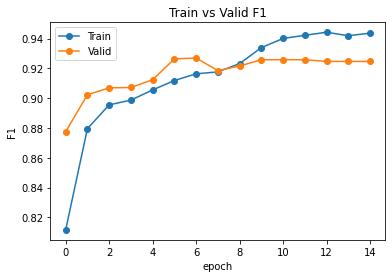

In [82]:
# freeze inception seed 84 1e-3 maxpool drop 0.2
show_graph(train_f1_list, val_f1_list, epoch_list)

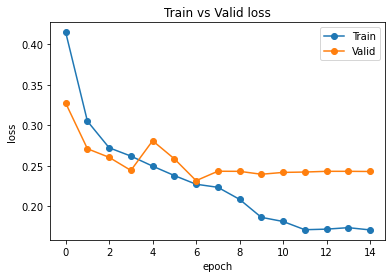

In [83]:
# freeze inception seed 84 1e-3 maxpool drop 0.2
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

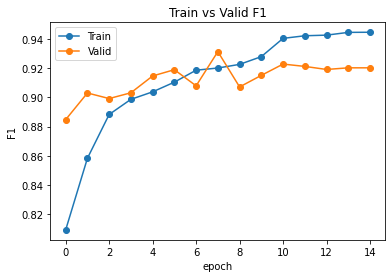

In [92]:
# freeze inception seed 7 1e-3 maxpool drop 0.1
show_graph(train_f1_list, val_f1_list, epoch_list)

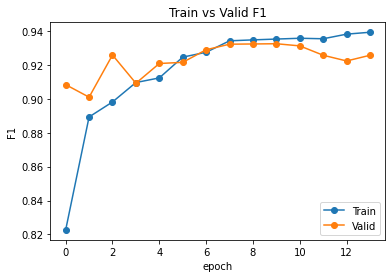

In [90]:
# freeze inception seed 25 1e-3 maxpool drop 0.1
show_graph(train_f1_list, val_f1_list, epoch_list)

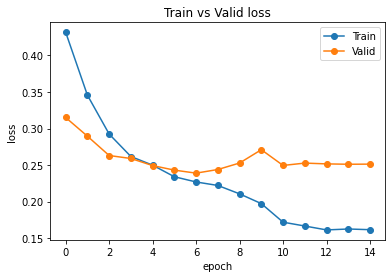

In [93]:
# freeze inception seed 7 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

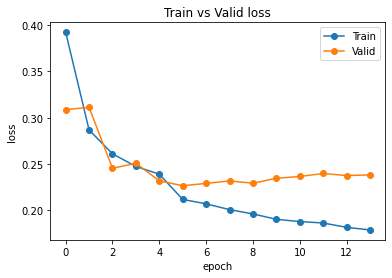

In [91]:
# freeze inception seed 25 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

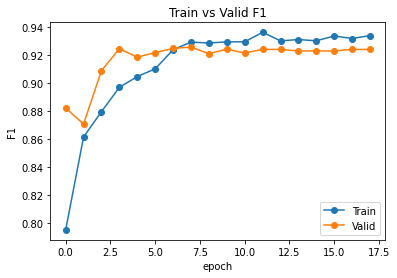

In [90]:
# freeze inception seed 0 1e-3 maxpool drop 0.1
show_graph(train_f1_list, val_f1_list, epoch_list)

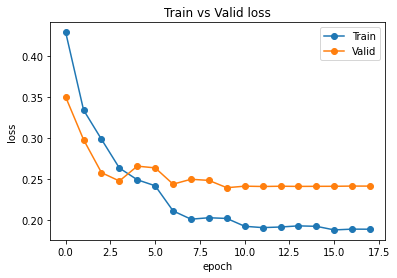

In [95]:
# freeze inception seed 0 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

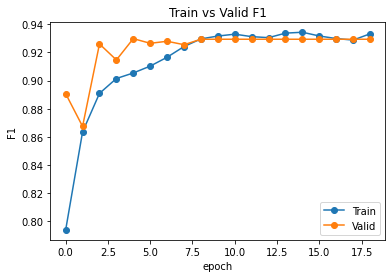

In [90]:
# freeze inception seed 66 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

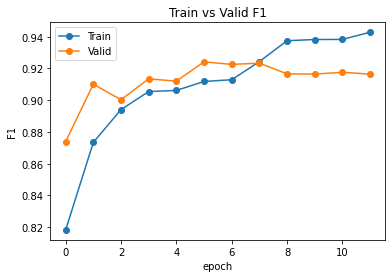

In [90]:
# freeze inception seed 25 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

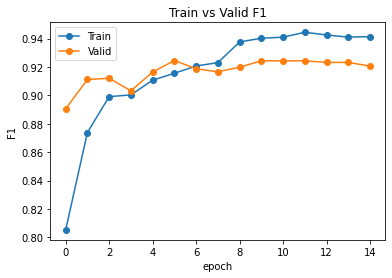

In [88]:
# freeze inception seed 84 1e-3
show_graph(train_f1_list, val_f1_list, epoch_list)

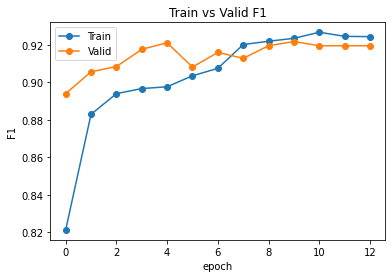

In [96]:
# freeze inception seed 84
show_graph(train_f1_list, val_f1_list, epoch_list)

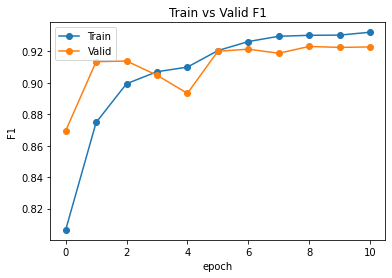

In [88]:
# freeze inception seed 25 1e-3
show_graph(train_f1_list, val_f1_list, epoch_list)

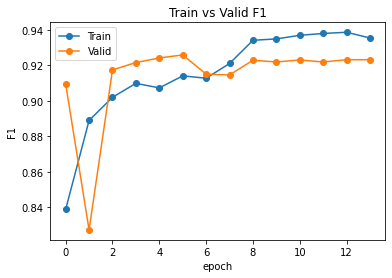

In [85]:
# freeze inception 66
show_graph(train_f1_list, val_f1_list, epoch_list)

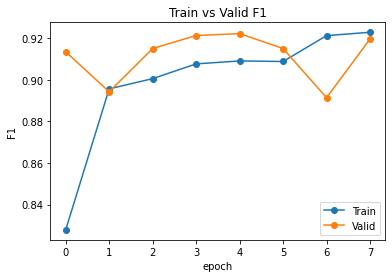

In [80]:
# freeze inception
show_graph(train_f1_list, val_f1_list, epoch_list)

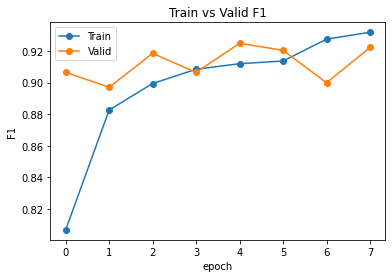

In [84]:
# freeze inception
show_graph(train_f1_list, val_f1_list, epoch_list)

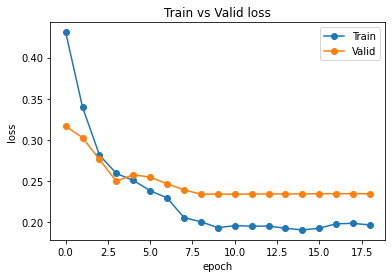

In [91]:
# freeze inception seed 66 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

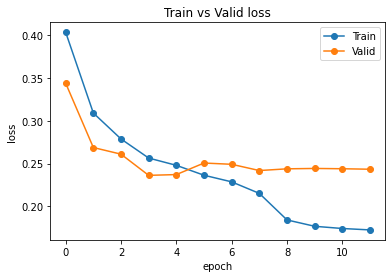

In [91]:
# freeze inception seed 25 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

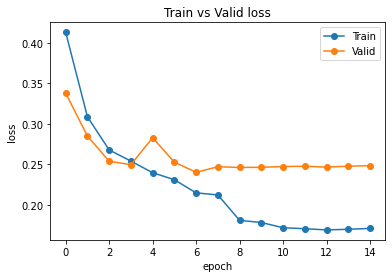

In [89]:
# freeze inception seed 84 1e-3
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

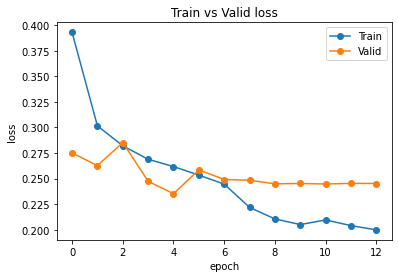

In [97]:
# freeze inception seed 84
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

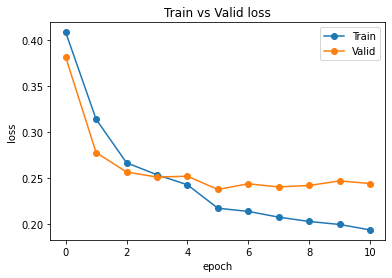

In [89]:
# freeze inception 25 1e-3
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

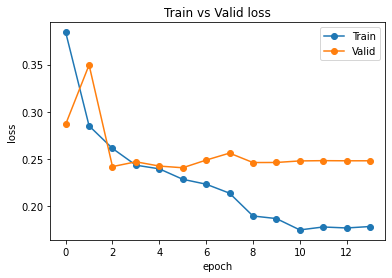

In [86]:
# freeze inception 66
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

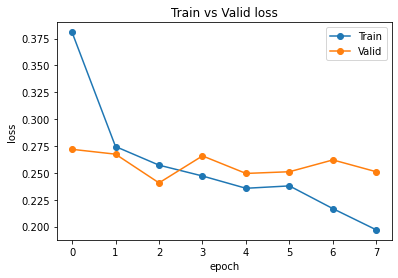

In [81]:
# freeze inception
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

In [78]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [98]:
import gc
del model 
gc.collect()

50

In [99]:
torch.cuda.empty_cache()

In [100]:
PATH = "my_checkpoint_attention_seed_149_1e-3_drop04.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
model = Concatmodal()
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print(checkpoint['epoch'])

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5


In [97]:
# f1
pred, score_preds, true = testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       302
         1.0       0.95      0.97      0.96       695

    accuracy                           0.95       997
   macro avg       0.94      0.93      0.94       997
weighted avg       0.95      0.95      0.95       997

test_ac 0.9458375125376128
Confusion [[268  34]
 [ 20 675]]
Macro_f1 0.935006518904824


In [101]:
# loss
pred, score_preds, true = testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       302
         1.0       0.95      0.97      0.96       695

    accuracy                           0.95       997
   macro avg       0.94      0.93      0.94       997
weighted avg       0.95      0.95      0.95       997

test_ac 0.9458375125376128
Confusion [[268  34]
 [ 20 675]]
Macro_f1 0.935006518904824


In [95]:
pred, score_preds, true = testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.92      0.89      0.91       302
         1.0       0.95      0.97      0.96       695

    accuracy                           0.94       997
   macro avg       0.94      0.93      0.93       997
weighted avg       0.94      0.94      0.94       997

test_ac 0.9438314944834504
Confusion [[270  32]
 [ 24 671]]
Macro_f1 0.9329915219248976


In [149]:
t = dm.test_data.reset_index(drop=True)

In [150]:
t['pred'] = pred
t
# wrong = t[t['pred'] != t['label']]

,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment,pred
0,4077,2521334,13201293,653281,Mình là khách quen của Loki cả trên Now và tại...,local1_folder-1/foody-loki-house-tao-pho-tra-s...,8.6,1,mình là khách quen của loki cả trên now và tại...,1.0
1,6448,2573475,14562049,890498,Mình đã gọi đây là một trong những quán cafe ...,local1_folder-1/foody-hoang-ha-bakery-coffee-5...,10.0,1,mình đã gọi đây là một trong những quán cafe đ...,1.0
2,4054,2895371,13967176,757432,Mình đã ăn rất nhiều lần và chỉ trung thành vớ...,local1_folder-1/foody-nem-nuong-nha-trang-co-h...,3.8,0,mình đã ăn rất nhiều lần và chỉ trung_thành vớ...,0.0
3,4280,3675043,15348110,649499,Cả nhà mình mua combo và thêm 4 cánh gà tổng h...,local1_folder-1/foody-pizza-hut-thai-thinh-758...,4.6,0,cả nhà mình mua combo và thêm 4 cánh_gà tổng h...,0.0
4,8947,6279731,1516967,791983,Thấy vắng nhưng đồ tươi nên mình ngồi ăn thử\n...,local1_folder-1/foody-xuan-seafood-hai-san-cac...,9.8,1,thấy vắng nhưng đồ tươi nên mình ngồi ăn thử n...,1.0
...,...,...,...,...,...,...,...,...,...,...
992,9729,3320053,9763313,954348,Check in luôn cho nóng hổi pà con ơi!ngon nhất...,local1_folder-1/foody-chu-beo-mi-y-mi-tron-onl...,10.0,1,check in luôn cho nóng_hổi pà con ơi ngon nhất...,1.0
993,1610,2055552,11034818,312332,"Mình đã ăn ở cá lăng thùy linh, món ăn rất ngo...",local1_folder-1/foody-ca-lang-thuy-linh-846-63...,10.0,1,mình đã ăn_ở cá_lăng thuỳ linh món ăn rất ngon...,1.0
994,3757,7626093,15768703,935465,"Ngon suất xắc luôn, 1 cốc to ú ụ, đóng gói cẩn...",local1_folder-1/foody-dong-duong-fruits-trai-c...,9.6,1,ngon suất xắc luôn 1 cốc to ú_ụ đóng_gói cẩn_t...,1.0
995,3288,13642297,23340870,1084759,Mình thấy quảng cáo bên thánh ăn. Có cái mâm ố...,local1_folder-1/foody-y-linh-oc-hai-san-duong-...,10.0,1,mình thấy quảng_cáo bên thánh ăn có cái mâm ốc...,1.0


In [151]:
print(t[t['index'] == 7142].iloc[0]['image_urls'])

local1_folder-1/foody-banh-ga-ba-ganh-ta-quang-buu-618-637326898510667082.jpg,local1_folder-1/foody-banh-ga-ba-ganh-ta-quang-buu-927-637326898504477654.jpg


In [152]:
wrong = pd.read_csv('wrongtext1.csv')
wrong

,level_0,index,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score,label,preprocess_comment,pred
0,14,8299,1198264,904147,211755,"Quán ngon từ ngoài vào khá là nhỏ, đi v...",local1_folder-1/foody-bot-cakes-drinks-670-636...,9.0,8.0,10.0,9.0,8.0,8.8,1,quán ngon từ ngoài vào khá là nhỏ đi vào trong...,0.0
1,18,9212,2553642,8793345,231313,Nếu ai biết chuyện của cô chắc chắn chả bao gi...,local1_folder-1/foody-chao-suon-co-la-959-6368...,5.0,5.0,4.0,4.0,5.0,4.6,0,nếu ai biết chuyện của cô chắc_chắn chả bao_gi...,1.0
2,54,9318,2987990,15053398,879917,nhìn khá đẹp mắt\nlá lốt ăn cảm giác chưa chín,local1_folder-1/foody-bong-bee-qua-vat-online-...,7.0,10.0,10.0,10.0,8.0,9.0,1,nhìn khá đẹp_mắt lá_lốt ăn cảm_giác chưa chín,0.0
3,68,9013,2789397,15711619,799242,"Ăn dc, hơi ít rau, có thêm đu đủ bào sợi với s...",local1_folder-1/foody-bamico-banh-mi-thit-nuon...,6.0,5.0,5.0,7.0,5.0,5.6,0,ăn dc hơi ít rau có thêm đu_đủ bào sợi với sốt...,1.0
4,88,5234,2624128,10674653,903842,Hôm nay tự dưng đứa e động vào máy đặt nhầm nh...,local1_folder-1/foody-royaltea-239-hoang-van-t...,9.0,9.0,8.0,8.0,8.0,8.4,1,hôm_nay tự_dưng đứa e động vào máy đặt nhầm nh...,0.0
5,147,9193,2476930,11909929,800995,"Cả quán 5 nhân viên, lác đác vài khách mà đợi ...",local1_folder-1/foody-fruity-fact-ly-thuong-ki...,4.0,1.0,6.0,5.0,6.0,4.4,0,cả quán 5 nhân_viên lác_đác vài khách mà đợi h...,1.0
6,181,449,2461821,13313145,163311,Bọn mh đã gọi điện đặt trước để hưởng ưu đãi t...,local1_folder-1/foody-daruma-quan-an-nhat-ban-...,7.0,8.0,10.0,10.0,5.0,8.0,1,bọn mh đã gọi điện đặt trước để hưởng ưu_đãi t...,0.0
7,228,4675,5106328,20366407,871898,Minh hay đăt ở đây vì luôncó giam giaz,local1_folder-1/foody-com-tam-duong-thai-thinh...,9.0,10.0,7.0,10.0,10.0,9.2,1,minh hay đăt ở đây vì luôncó giam giaz,0.0
8,235,2547,5896562,15819975,946441,Lâu nay tòan uống sữa tươi với trà sữa đường đ...,local1_folder-1/foody-tra-sua-tocotoco-truong-...,7.0,5.0,5.0,5.0,6.0,5.6,0,lâu_nay toàn uống sữa_tươi với trà sữa đường đ...,1.0
9,239,80,1706791,535157,692942,Đây là cơ sở thứ 5 của chuỗi quán đồ nướng 61 ...,local1_folder-1/foody-do-nuong-692942-582-6364...,2.0,6.0,6.0,6.0,5.0,5.0,0,đây là cơ_sở thứ 5 của chuỗi quán đồ nướng 61 ...,1.0


In [153]:
t = t.filter(items = wrong['level_0'], axis=0)
t

,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment,pred
14,8299,1198264,904147,211755,"Quán ngon từ ngoài vào khá là nhỏ, đi v...",local1_folder-1/foody-bot-cakes-drinks-670-636...,8.8,1,quán ngon từ ngoài vào khá là nhỏ đi vào trong...,0.0
18,9212,2553642,8793345,231313,Nếu ai biết chuyện của cô chắc chắn chả bao gi...,local1_folder-1/foody-chao-suon-co-la-959-6368...,4.6,0,nếu ai biết chuyện của cô chắc_chắn chả bao_gi...,1.0
54,9318,2987990,15053398,879917,nhìn khá đẹp mắt\nlá lốt ăn cảm giác chưa chín,local1_folder-1/foody-bong-bee-qua-vat-online-...,9.0,1,nhìn khá đẹp_mắt lá_lốt ăn cảm_giác chưa chín,0.0
68,9013,2789397,15711619,799242,"Ăn dc, hơi ít rau, có thêm đu đủ bào sợi với s...",local1_folder-1/foody-bamico-banh-mi-thit-nuon...,5.6,0,ăn dc hơi ít rau có thêm đu_đủ bào sợi với sốt...,1.0
88,5234,2624128,10674653,903842,Hôm nay tự dưng đứa e động vào máy đặt nhầm nh...,local1_folder-1/foody-royaltea-239-hoang-van-t...,8.4,1,hôm_nay tự_dưng đứa e động vào máy đặt nhầm nh...,1.0
147,9193,2476930,11909929,800995,"Cả quán 5 nhân viên, lác đác vài khách mà đợi ...",local1_folder-1/foody-fruity-fact-ly-thuong-ki...,4.4,0,cả quán 5 nhân_viên lác_đác vài khách mà đợi h...,1.0
181,449,2461821,13313145,163311,Bọn mh đã gọi điện đặt trước để hưởng ưu đãi t...,local1_folder-1/foody-daruma-quan-an-nhat-ban-...,8.0,1,bọn mh đã gọi điện đặt trước để hưởng ưu_đãi t...,0.0
228,4675,5106328,20366407,871898,Minh hay đăt ở đây vì luôncó giam giaz,local1_folder-1/foody-com-tam-duong-thai-thinh...,9.2,1,minh hay đăt ở đây vì luôncó giam giaz,0.0
235,2547,5896562,15819975,946441,Lâu nay tòan uống sữa tươi với trà sữa đường đ...,local1_folder-1/foody-tra-sua-tocotoco-truong-...,5.6,0,lâu_nay toàn uống sữa_tươi với trà sữa đường đ...,0.0
239,80,1706791,535157,692942,Đây là cơ sở thứ 5 của chuỗi quán đồ nướng 61 ...,local1_folder-1/foody-do-nuong-692942-582-6364...,5.0,0,đây là cơ_sở thứ 5 của chuỗi quán đồ nướng 61 ...,1.0


In [156]:
t['text_pred'] = list(wrong['pred'])
t = t.reset_index(drop=True)
t

,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment,pred,text_pred
0,8299,1198264,904147,211755,"Quán ngon từ ngoài vào khá là nhỏ, đi v...",local1_folder-1/foody-bot-cakes-drinks-670-636...,8.8,1,quán ngon từ ngoài vào khá là nhỏ đi vào trong...,0.0,0.0
1,9212,2553642,8793345,231313,Nếu ai biết chuyện của cô chắc chắn chả bao gi...,local1_folder-1/foody-chao-suon-co-la-959-6368...,4.6,0,nếu ai biết chuyện của cô chắc_chắn chả bao_gi...,1.0,1.0
2,9318,2987990,15053398,879917,nhìn khá đẹp mắt\nlá lốt ăn cảm giác chưa chín,local1_folder-1/foody-bong-bee-qua-vat-online-...,9.0,1,nhìn khá đẹp_mắt lá_lốt ăn cảm_giác chưa chín,0.0,0.0
3,9013,2789397,15711619,799242,"Ăn dc, hơi ít rau, có thêm đu đủ bào sợi với s...",local1_folder-1/foody-bamico-banh-mi-thit-nuon...,5.6,0,ăn dc hơi ít rau có thêm đu_đủ bào sợi với sốt...,1.0,1.0
4,5234,2624128,10674653,903842,Hôm nay tự dưng đứa e động vào máy đặt nhầm nh...,local1_folder-1/foody-royaltea-239-hoang-van-t...,8.4,1,hôm_nay tự_dưng đứa e động vào máy đặt nhầm nh...,1.0,0.0
5,9193,2476930,11909929,800995,"Cả quán 5 nhân viên, lác đác vài khách mà đợi ...",local1_folder-1/foody-fruity-fact-ly-thuong-ki...,4.4,0,cả quán 5 nhân_viên lác_đác vài khách mà đợi h...,1.0,1.0
6,449,2461821,13313145,163311,Bọn mh đã gọi điện đặt trước để hưởng ưu đãi t...,local1_folder-1/foody-daruma-quan-an-nhat-ban-...,8.0,1,bọn mh đã gọi điện đặt trước để hưởng ưu_đãi t...,0.0,0.0
7,4675,5106328,20366407,871898,Minh hay đăt ở đây vì luôncó giam giaz,local1_folder-1/foody-com-tam-duong-thai-thinh...,9.2,1,minh hay đăt ở đây vì luôncó giam giaz,0.0,0.0
8,2547,5896562,15819975,946441,Lâu nay tòan uống sữa tươi với trà sữa đường đ...,local1_folder-1/foody-tra-sua-tocotoco-truong-...,5.6,0,lâu_nay toàn uống sữa_tươi với trà sữa đường đ...,0.0,1.0
9,80,1706791,535157,692942,Đây là cơ sở thứ 5 của chuỗi quán đồ nướng 61 ...,local1_folder-1/foody-do-nuong-692942-582-6364...,5.0,0,đây là cơ_sở thứ 5 của chuỗi quán đồ nướng 61 ...,1.0,1.0


In [159]:
print(t.iloc[39]['image_urls'])
t.iloc[39]['preprocess_comment']

local1_folder-1/foody-highlands-coffee-bt5-van-quan-973-637048317778406657.jpg,local1_folder-1/foody-highlands-coffee-bt5-van-quan-290-637048317775125110.jpg


'thèm trà đào vào highland văn quán oder cốc trà đào 55k được 4 miếng đào mỏng_dính trong khi củng giá đó ra an coffe văn quán sang choảnh đẹp_đẽ các bạn nhân_viên nhiệt_tình khéo phải cho mình đến cả nửa quả đào trà vừa thơm lại ko ngọt quá nói_chung là gần cty thử 1 lần xong say goobye never come back nhé'

local1_folder-1/foody-highlands-coffee-bt5-van-quan-973-637048317778406657.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x1067 at 0x7FF5787C7A30>
(1067, 800, 3)


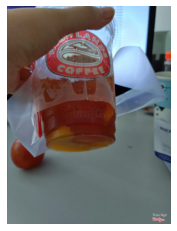

In [161]:
img_path = 'local1_folder-1/foody-highlands-coffee-bt5-van-quan-973-637048317778406657.jpg'
print(img_path)
img = Image.open(data_zip.open(img_path))
# img.save('VD4.jpg')
print(img)
print(np.asarray(img).shape)
plt.axis('off')
plt.imshow(img)

In [75]:
optimizer = torch.optim.Adam([
        {'params': model.BERT.lstm.parameters()},  
        {'params': model.incept.flat.parameters()}, 
        {'params': model.incept.avgpool.parameters()},  
        {'params': model.dense.parameters()},       
        {'params': model.cl.parameters()},       
        {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
        {'params': model.incept.incept.parameters(), 'lr': 1e-5}
    ], lr=1e-3)
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


In [117]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true, score_preds[:,1], pos_label = 1)